# Data Cleaning and EDA

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.style as style
from matplotlib_venn import venn2
import seaborn as sns
import re

from nltk.tokenize import RegexpTokenizer
from nltk import WordNetLemmatizer
from nltk.stem import PorterStemmer

from sklearn.feature_extraction.text import CountVectorizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer

pd.set_option('display.max_columns', None)
style.use('seaborn-whitegrid')
sns.set_context('notebook', font_scale=1.2)

### Load and Explore Data

In [2]:
ghome = pd.read_csv('../datasets/ghome.csv')
aecho = pd.read_csv('../datasets/aecho.csv')

We are concerned with text data concerned within the title and selftext column. We also decide to keep the subreddit, author, time and reddit score (number of upvotes - number of downvotes) data.

In [3]:
ghome.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 84 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   all_awardings                  3000 non-null   object 
 1   allow_live_comments            3000 non-null   bool   
 2   author                         3000 non-null   object 
 3   author_flair_css_class         2 non-null      object 
 4   author_flair_richtext          2969 non-null   object 
 5   author_flair_text              48 non-null     object 
 6   author_flair_type              2969 non-null   object 
 7   author_fullname                2969 non-null   object 
 8   author_patreon_flair           2969 non-null   object 
 9   author_premium                 2969 non-null   object 
 10  awarders                       3000 non-null   object 
 11  can_mod_post                   3000 non-null   bool   
 12  contest_mode                   3000 non-null   b

In [4]:
# Keep only useful columns 
cols = ['subreddit', 'author', 'title', 'selftext', 'created_utc', 'score']
ghome_1 = ghome.loc[:, cols]
aecho_1 = aecho.loc[:, cols]

In [5]:
# Convert time to UTC
ghome_1['created_utc'] = pd.to_datetime(ghome_1['created_utc'], unit='s')
aecho_1['created_utc'] = pd.to_datetime(aecho_1['created_utc'], unit='s')

In [6]:
# Join both subreddits' data for cleaning
df = pd.concat([ghome_1, aecho_1], axis=0, ignore_index=True)

### Text Cleaning

In [7]:
# Fill NA rows in selftext with blanks
df['selftext'].fillna('',inplace=True)

We are interested in analysing both the title and selftext together as a single post. We thus combine both fields into a single post field, with a | character as a separator.

In [8]:
df['post'] = df['title'] + ' | ' + df['selftext']

Looking at duplicate posts, most are spam posts. We thus remove these outliers as they do not provide us with sentiment information on the products.

In [9]:
df[df.duplicated(subset='post')].head(10)

,subreddit,author,title,selftext,created_utc,score,post
142,googlehome,IsabelOno,Buy Sitejabber Reviews - 100% Safe nondrop USA...,,2021-04-14 17:14:55,1,Buy Sitejabber Reviews - 100% Safe nondrop USA...
144,googlehome,ElizabethHare,Buy Sitejabber Reviews - 100% Safe nondrop USA...,,2021-04-14 17:02:11,1,Buy Sitejabber Reviews - 100% Safe nondrop USA...
145,googlehome,JudyMayer,Buy Sitejabber Reviews - 100% Safe nondrop USA...,,2021-04-14 16:56:05,1,Buy Sitejabber Reviews - 100% Safe nondrop USA...
146,googlehome,KayHarri,Buy Sitejabber Reviews - 100% Safe nondrop USA...,,2021-04-14 16:52:59,1,Buy Sitejabber Reviews - 100% Safe nondrop USA...
147,googlehome,MelodyBrim,Buy Sitejabber Reviews - 100% Safe nondrop USA...,,2021-04-14 16:48:41,1,Buy Sitejabber Reviews - 100% Safe nondrop USA...
149,googlehome,BettyRunner,Buy Sitejabber Reviews - 100% Safe nondrop USA...,,2021-04-14 16:19:17,1,Buy Sitejabber Reviews - 100% Safe nondrop USA...
277,googlehome,MarilynFerrara,Buy Facebook Reviews - USA Facebook Page Posit...,,2021-04-06 11:56:19,1,Buy Facebook Reviews - USA Facebook Page Posit...
278,googlehome,MelissaRo55,Buy Facebook Reviews - USA Facebook Page Posit...,,2021-04-06 11:52:12,1,Buy Facebook Reviews - USA Facebook Page Posit...
279,googlehome,KellyPerkin,Buy Facebook Reviews - USA Facebook Page Posit...,,2021-04-06 11:43:52,1,Buy Facebook Reviews - USA Facebook Page Posit...
280,googlehome,PatriciaMarti,Buy Facebook Reviews - USA Facebook Page Posit...,,2021-04-06 11:37:44,1,Buy Facebook Reviews - USA Facebook Page Posit...


In [10]:
df.drop_duplicates(subset='post', keep=False, inplace=True)

#### Removing special characters, links etc.
Before we explore the text data, we need to clean it. We need to remove the following:
* Special Characters
* Links (which are largely spam)
* Text that indicates a post is removed or deleted by the moderators

In [11]:
df['post'].str.contains('\[removed\]').sum()

192

In [12]:
df['post'].str.contains('\[deleted\]').sum()

53

In [13]:
df['post'].str.contains('\\n').sum()

2525

In [14]:
def clean_text(text):
    """
    Input: Text
    Output: Cleaned lowercase text with special characters, links, text that indicates a post is removed or deleted by the moderators, and extra whitespaces removed.       It also handles apostrophes by joining words (e.g. i'm and we've to im and weve respectively).
    """
    text = text.lower()
    text = re.sub('\[removed\]', ' ', text)
    text = re.sub('\[deleted\]', ' ', text)
    text = re.sub('\\n', ' ', text)
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text)
    text = re.sub("\'", '', text)
    text = re.sub('[^0-9A-Za-z|\s]', ' ', text)
    text = re.sub('\s+', ' ', text)
    return text

In [15]:
df['post'][0]

"Does anyone know how to fix this? Since yesterday my google home doesn't respond anymore. Google Home app doesn't see the device. When I turned it off and on, these two lights stay on. Also can't factory reset... | "

In [16]:
clean_text(df['post'][0])

'does anyone know how to fix this since yesterday my google home doesnt respond anymore google home app doesnt see the device when i turned it off and on these two lights stay on also cant factory reset | '

#### Lemmatizing Text
We also want to run the text data through a Lemmatizer to reduce inflectional forms. I chose to use a lemmatizer instead of a stemmer as the resultant word is still a word in most cases after lemmatizing and is easily comprehensible, compared to stemming which is more crude. 

In [17]:
wnl = WordNetLemmatizer()
def lemmatize_text(text):
    """
    Input: Text
    Output: Text with each word lemmatized.
    """
    words = text.split()
    words_lem = []
    for word in words:
        word_lem = wnl.lemmatize(word)
        words_lem.append(word_lem)
    join_words_lem = ' '.join(words_lem)
    return join_words_lem

In [18]:
lemmatize_text(clean_text(df['post'][0]))

'doe anyone know how to fix this since yesterday my google home doesnt respond anymore google home app doesnt see the device when i turned it off and on these two light stay on also cant factory reset |'

In [19]:
df['clean_post'] = df['post'].apply(clean_text).apply(lemmatize_text)

#### Removing posts with less than 10 words
Posts with less than 10 words are unlikely to contain much useful information. We thus choose to remove these posts from the dataset

In [20]:
df['word_count'] = df['clean_post'].apply(lambda x: len(x.split()))

In [21]:
df[df['word_count']<10].head()

,subreddit,author,title,selftext,created_utc,score,post,clean_post,word_count
6,googlehome,Armada99,There was an attempt.........,,2021-04-19 02:02:43,1,There was an attempt......... |,there wa an attempt |,5
15,googlehome,Double-Pollution6065,New Nest thermostat for $99!,,2021-04-18 20:48:24,1,New Nest thermostat for $99! |,new nest thermostat for 99 |,6
28,googlehome,Complex_League_5287,What if Google does not exist,,2021-04-18 12:40:29,1,What if Google does not exist |,what if google doe not exist |,7
29,googlehome,iansime,Bathroom Cabinet with Google Assistant,,2021-04-18 11:29:02,1,Bathroom Cabinet with Google Assistant |,bathroom cabinet with google assistant |,6
35,googlehome,houstonhardimon,Donald Trump,,2021-04-18 02:59:12,1,Donald Trump |,donald trump |,3


In [22]:
df_at_least_10_words = df.drop(df[df['word_count']<10].index)

In [23]:
ghome_clean = df_at_least_10_words.loc[df_at_least_10_words["subreddit"]==("googlehome"), :].copy()
aecho_clean = df_at_least_10_words.loc[df_at_least_10_words["subreddit"]==("amazonecho"), :].copy()

#### Checking shape and save cleaned data

In [24]:
print(ghome_clean.shape)
print(aecho_clean.shape)

(2498, 9)
(2609, 9)


In [25]:
ghome_clean.to_csv('../datasets/ghome_clean.csv', index=False)
aecho_clean.to_csv('../datasets/aecho_clean.csv', index=False)

## EDA

In [26]:
# Load data
ghome = pd.read_csv('../datasets/ghome_clean.csv')
aecho = pd.read_csv('../datasets/aecho_clean.csv')

In [27]:
ghome.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2498 entries, 0 to 2497
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   subreddit    2498 non-null   object
 1   author       2498 non-null   object
 2   title        2498 non-null   object
 3   selftext     2130 non-null   object
 4   created_utc  2498 non-null   object
 5   score        2498 non-null   int64 
 6   post         2498 non-null   object
 7   clean_post   2498 non-null   object
 8   word_count   2498 non-null   int64 
dtypes: int64(2), object(7)
memory usage: 175.8+ KB


In [28]:
ghome.describe()

,score,word_count
count,2498.000000,2498.00000
mean,3.251401,83.88791
std,21.977508,68.09692
min,0.000000,10.00000
25%,1.000000,39.00000
50%,1.000000,69.00000
75%,1.000000,110.00000
max,640.000000,867.00000


In [29]:
aecho.describe()

,score,word_count
count,2609.000000,2609.000000
mean,1.581832,82.628593
std,7.632741,68.425425
min,0.000000,10.000000
25%,1.000000,39.000000
50%,1.000000,68.000000
75%,1.000000,107.000000
max,265.000000,805.000000


#### CountVectorize Words
We use CountVectorizer to allow us to break up each post into its constituent words, in order for us to determine the most common words in each subreddit. We remove not informative words that occur commonly (stop words) in the language (e.g. pronouns). We only include words that appear in at least 3 posts. We also use combinations of 2 words (word-pairs). There are close to 7000 words/word-pairs in each dataset that fit this criteria.

In [30]:
cvec = CountVectorizer(stop_words='english', min_df=3, ngram_range=(1,2))
ghome_cv = cvec.fit_transform(ghome['clean_post'])
ghome_words = pd.DataFrame(ghome_cv.todense(), columns=cvec.get_feature_names())

In [31]:
cvec = CountVectorizer(stop_words='english', min_df=3, ngram_range=(1,2))
aecho_cv = cvec.fit_transform(aecho['clean_post'])
aecho_words = pd.DataFrame(aecho_cv.todense(), columns=cvec.get_feature_names())

In [32]:
ghome_words.shape

(2498, 6729)

In [33]:
aecho_words.shape

(2609, 6966)

In [34]:
ghome_top = ghome_words.sum().sort_values(ascending=False).head(20).to_frame(name='count')

In [35]:
aecho_top = aecho_words.sum().sort_values(ascending=False).head(20).to_frame(name='count')

### Most Common Words
It is not surprising to find that the most common words in each subreddit correspond to brand names e.g. home and nest for google, echo and dot for amazon.

A consequence of lemmatizing is that there are words like ha and wa which correspond to has and was respectively. These can be ignored in our analysis.

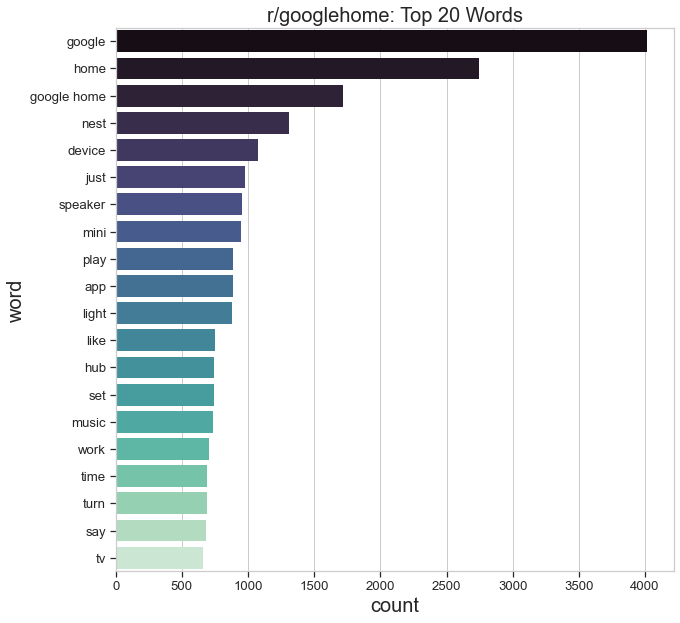

In [36]:
plt.figure(figsize=(10,10))
sns.barplot(data=ghome_top, x='count', y=ghome_top.index,orient='h',palette="mako")
plt.title('r/googlehome: Top 20 Words',fontsize=20)
plt.xlabel('count',fontsize=20)
plt.ylabel('word',fontsize=20)
plt.savefig('../images/gh_common_words.png', bbox_inches='tight', facecolor='w')
plt.show()

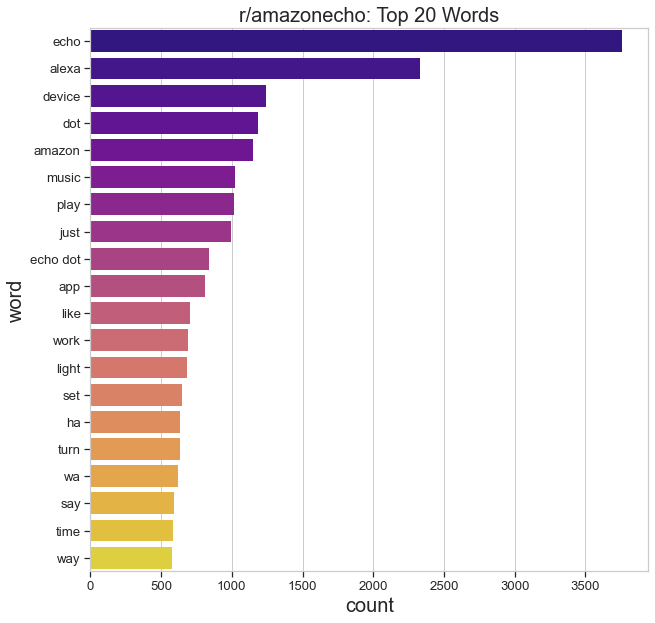

In [37]:
plt.figure(figsize=(10,10))
sns.barplot(data=aecho_top, x='count', y=aecho_top.index,orient='h',palette='plasma')
plt.title('r/amazonecho: Top 20 Words',fontsize=20)
plt.xlabel('count',fontsize=20)
plt.ylabel('word',fontsize=20)
plt.savefig('../images/ae_common_words.png', bbox_inches='tight', facecolor='w')
plt.show()

Looking at the most common words in each subreddit, we find that many words are shared across both subreddits, as these refer to words relating to smart speakers.

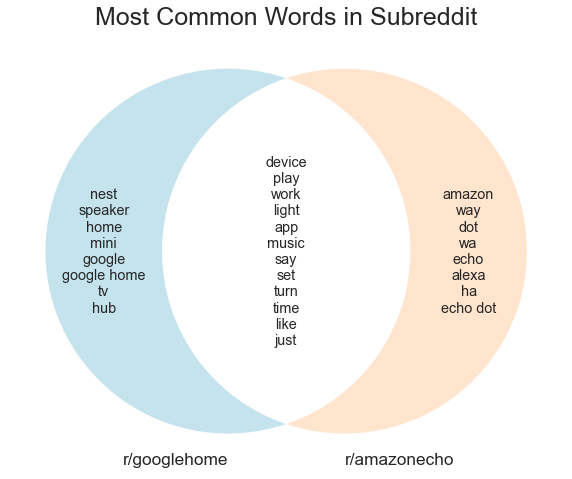

In [38]:
set_a = set(ghome_top.index)
set_b = set(aecho_top.index)

plt.figure(figsize=(10,10))
venn = venn2([set_a,set_b], set_labels=['r/googlehome','r/amazonecho'], set_colors=('lightblue', 'peachpuff'), alpha=0.7)

venn.get_label_by_id('100').set_text('\n'.join(map(str,set_a-set_b)))
venn.get_label_by_id('110').set_text('\n'.join(map(str,set_a&set_b)))
venn.get_label_by_id('010').set_text('\n'.join(map(str,set_b-set_a)))

plt.title('Most Common Words in Subreddit',fontsize=25)
plt.savefig('../images/both_common_words.png', bbox_inches='tight', facecolor='w')
plt.show()

### Sentiment Analysis
We use NLTK VADER, a built in sentiment analysis tool to determine the overall valence of posts on each subreddit. The sentiment tool takes each post, checks the post for emotive words (including negations and contractions), and generates 3 polarity scores between 0 and 1 reflecting the proportion of negative, neutral and positive sentiment, and a compound score between -1 and 1 reflecting the overall sentiment with 0 being neutral.

We can see an example of a positive and negative post below.

In [39]:
ghome[ghome['clean_post'].str.contains('i love')]['post'].head(30)[2363]

'I just want to say I love the color of my new mini. I wish I got another in the aqua color | '

In [40]:
sid = SentimentIntensityAnalyzer()
sid.polarity_scores(ghome['clean_post'][2363])

{'neg': 0.0, 'neu': 0.647, 'pos': 0.353, 'compound': 0.802}

In [41]:
ghome[ghome['clean_post'].str.contains('awful')]['post'].head(30)[183]

'Nest App (Android) Getting Worse? | Hi, \n\nI have had some nest cameras for a while now and have used the app for the entire time. As of the past few months scrubbing through video is awful. The process of find the event isn\'t terrible, but when trying to view it doesn\'t auto play. So when I select a time to start at in the past it won\'t play unless I go in the "People" tab and back out of it. The other issues I have is when I go into full screen into my nest doorbell it has an extremely messed up aspect ratio, but my other cameras do not do the same. \n\nI tried searching this subreddit and didn\'t see any post about this. Wondering if I am the only one, or are other people experiencing this?\n\nThanks.'

In [42]:
sid.polarity_scores(aecho['clean_post'][183])

{'neg': 0.08, 'neu': 0.864, 'pos': 0.056, 'compound': -0.1779}

#### Generating polarity scores for each post in dataframe

In [43]:
# Iterates through each row, gets the clean_post, runs the sentiment analyzer, and appends score to the row in appropriate column.
for index, row in aecho.iterrows():
    polarity_score = sid.polarity_scores(row['clean_post'])
    aecho.at[index,'neg'] = polarity_score['neg']
    aecho.at[index,'neu'] = polarity_score['neu']
    aecho.at[index,'pos'] = polarity_score['pos']
    aecho.at[index,'compound'] = polarity_score['compound']

In [44]:
for index, row in ghome.iterrows():
    polarity_score = sid.polarity_scores(row['clean_post'])
    ghome.at[index,'neg'] = polarity_score['neg']
    ghome.at[index,'neu'] = polarity_score['neu']
    ghome.at[index,'pos'] = polarity_score['pos']
    ghome.at[index,'compound'] = polarity_score['compound']

#### Findings
r/amazonecho has higher positive sentiment scores, and slightly higher negative sentiment scores. Overall, the compound scores are slightly higher for r/amazonecho compared to r/googlehome. This addresses the problem statement.

In [45]:
print(f'r/googlehome Mean Positive Score: {ghome["pos"].mean()}')
print(f'r/googlehome Mean Negative Score: {ghome["neg"].mean()}')
print(f'r/googlehome Mean Compound Score: {ghome["compound"].mean()}')
print('')
print(f'r/amazonecho Mean Positive Score: {aecho["pos"].mean()}')
print(f'r/amazonecho Mean Negative Score: {aecho["neg"].mean()}')
print(f'r/amazonecho Mean Compound Score: {aecho["compound"].mean()}')

r/googlehome Mean Positive Score: 0.1003070456365092
r/googlehome Mean Negative Score: 0.048934747798238726
r/googlehome Mean Compound Score: 0.3012881905524423

r/amazonecho Mean Positive Score: 0.11027865082407058
r/amazonecho Mean Negative Score: 0.04986239938673824
r/amazonecho Mean Compound Score: 0.30991069375239544


Looking at the probability distribution of sentiment scores, both subreddit distributions are relatively similar, with slightly higher counts of positive sentiments across r/amazonecho compared to r/googlehome, echoing the mean scores.

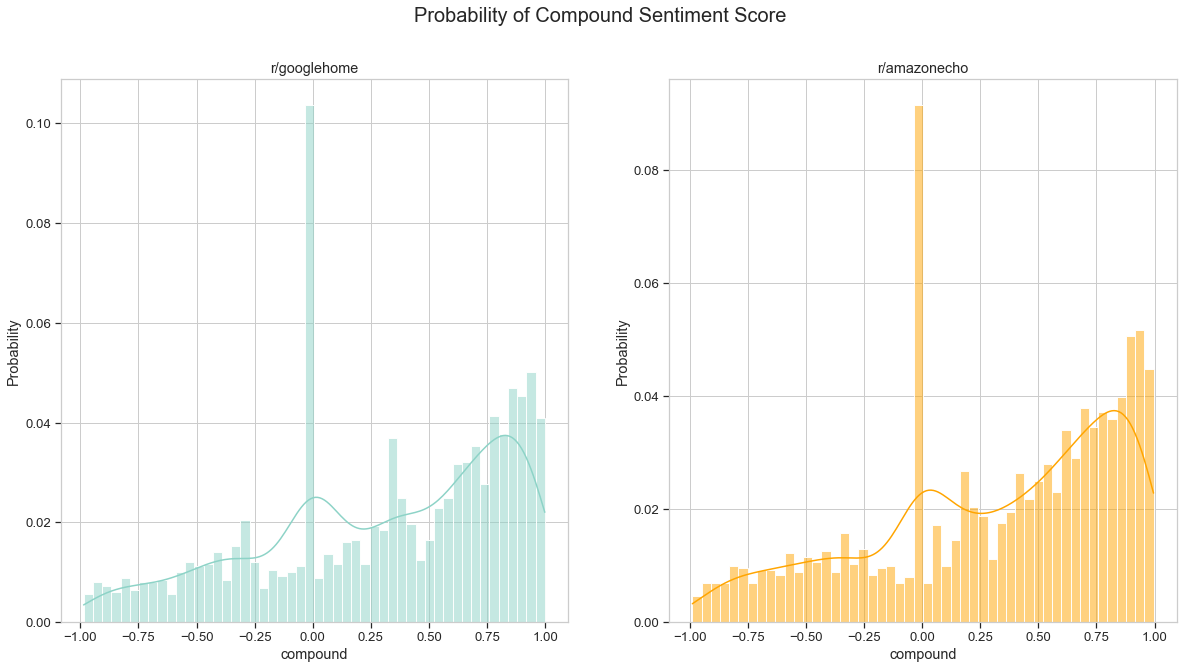

In [46]:
fig,ax = plt.subplots(1,2, figsize=(20,10))
sns.histplot(data=ghome['compound'], stat='probability', bins=50, kde=True, ax=ax[0])
sns.histplot(data=aecho['compound'], stat='probability', bins=50, kde=True, color='orange', ax=ax[1])
ax[0].title.set_text('r/googlehome')
ax[1].title.set_text('r/amazonecho')
fig.suptitle('Probability of Compound Sentiment Score', size=20)
plt.savefig('../images/sentimentscore.png', bbox_inches='tight', facecolor='w')
plt.show()

Looking at the density plot of compound scores, sentiment in both subreddits seems to be relatively similar.

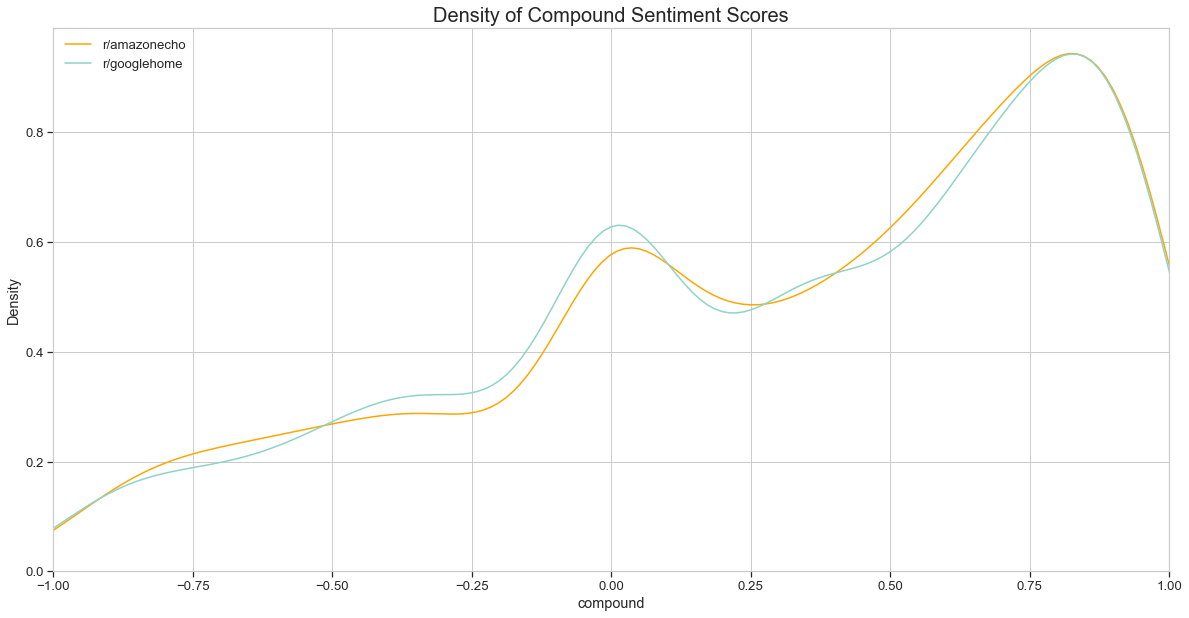

In [47]:
plt.figure(figsize=(20,10))
plt.xlim(-1,1)
sns.kdeplot(data=aecho['compound'], color='orange', label='r/amazonecho')
sns.kdeplot(data=ghome['compound'], label='r/googlehome')
plt.legend(['r/amazonecho', 'r/googlehome'])

plt.title('Density of Compound Sentiment Scores', size=20)
plt.savefig('../images/sentiment_density.png', bbox_inches='tight', facecolor='w')
plt.show()